In [3]:
import torch.nn as nn
import torch
import torchvision.models as models
import torch.nn.functional as F
import time,copy
from torchsummary import summary

In [33]:
class CNNModel(nn.Module):

    def __init__(self):
        super().__init__()
        resnet = models.resnet152(pretrained=True)
        self.resnet_head = list(resnet.children())[:-1]
        self.ConvoLSTM = self.get_model()
        print(list(self.ConvoLSTM.parameters()))

    def get_model(self):
        ConvoLSTM = nn.Sequential(
            nn.Sequential(*self.resnet_head),
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        return ConvoLSTM

In [16]:
convoLSTM = CNNModel()


[Parameter containing:
tensor([[[[ 4.7132e-07,  6.3123e-07,  6.1915e-07,  ...,  2.9313e-07,
            2.1123e-07,  1.3036e-07],
          [ 4.8263e-07,  7.1548e-07,  7.1251e-07,  ...,  3.0581e-07,
            2.6611e-07,  2.3413e-07],
          [ 4.9888e-07,  6.3326e-07,  6.1920e-07,  ...,  1.2629e-07,
            1.8429e-07,  2.0732e-07],
          ...,
          [ 5.5013e-07,  3.1735e-07,  4.1098e-07,  ...,  3.1079e-07,
            3.4928e-07,  3.4718e-07],
          [ 6.2982e-07,  4.0325e-07,  3.4432e-07,  ...,  4.8297e-07,
            6.4529e-07,  5.4214e-07],
          [ 7.1402e-07,  5.0883e-07,  4.4785e-07,  ...,  6.2946e-07,
            6.5617e-07,  5.0979e-07]],

         [[ 5.0878e-07,  6.8802e-07,  6.1782e-07,  ...,  2.2142e-07,
            2.1541e-07,  1.8464e-07],
          [ 4.2393e-07,  6.5220e-07,  6.2894e-07,  ...,  2.8318e-07,
            2.5690e-07,  2.3177e-07],
          [ 4.6649e-07,  6.4230e-07,  6.2854e-07,  ...,  1.3226e-07,
            2.2451e-07,  2.1060e-07

In [22]:
o = torch.randn((4,200,1,1))

In [31]:
m = nn.Flatten()

In [32]:
m(o).shape

torch.Size([4, 200])

In [23]:
o.shape

torch.Size([4, 200, 1, 1])

In [34]:
convoLSTM(torch.randn((3,220,220)))

NotImplementedError: 

In [8]:
summary(models.resnet152(),(3,220,220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,408
       BatchNorm2d-2         [-1, 64, 110, 110]             128
              ReLU-3         [-1, 64, 110, 110]               0
         MaxPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5           [-1, 64, 55, 55]           4,096
       BatchNorm2d-6           [-1, 64, 55, 55]             128
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]          36,864
       BatchNorm2d-9           [-1, 64, 55, 55]             128
             ReLU-10           [-1, 64, 55, 55]               0
           Conv2d-11          [-1, 256, 55, 55]          16,384
      BatchNorm2d-12          [-1, 256, 55, 55]             512
           Conv2d-13          [-1, 256, 55, 55]          16,384
      BatchNorm2d-14          [-1, 256,

In [30]:
class LMModel6(nn.Module):
    def __init__(self, vocab_sz=5, fc1=1024, fc2=512, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

SyntaxError: non-default argument follows default argument (<ipython-input-30-f39a0d621ebc>, line 2)

In [31]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(ConvoLSTM.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
train_model(ConvoLSTM, criterion, optimizer,exp_lr_scheduler)

Epoch 0/24
----------


NameError: name 'dataloaders' is not defined

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
resnet = models.resnet152(pretrained=True)

In [17]:
resnet_head = list(resnet.children())[:-1]
ConvoLSTM = nn.Sequential(
    nn.Sequential(*resnet_head),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024,512),
    nn.ReLU()
)

In [17]:
list(resnet.children())[-1].in_features

2048

In [24]:
import re

In [26]:
s = "v_GolfSwing_g01_c01"
re.search(s,"v_*_g")

In [36]:
m = re.search("v_(.*)_g",s)
if m:
m.group(1)

In [37]:
m.group(1)

'GolfSwing'

In [2]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch
import os
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
images = []
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((220,220))])
for path, subdirs, files in os.walk("/home/nitish/Downloads/ffmpeg/ALL_FRAMES/period_down/"):
    for name in files:
        image = Image.open(path+name).convert('RGB')
        image = transform(image)
        images.append((image))

In [3]:
images[0].shape

torch.Size([3, 220, 220])

In [21]:
torch.transpose(torch.transpose(images[0],0,2), 0,1 ).shape

torch.Size([220, 220, 3])

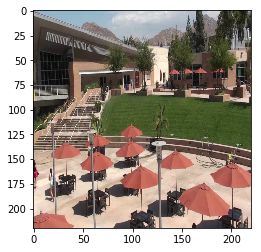

In [22]:
plt.imshow(torch.transpose(torch.transpose(images[0],0,2), 0,1 ))

In [17]:
torch.reshape?

In [34]:
transforms.Resize((220,220))

Resize(size=(220, 220), interpolation=PIL.Image.BILINEAR)

In [33]:
transforms.Resize?

In [3]:
import cv2
vidcap = cv2.VideoCapture('/home/nitish/Downloads/ffmpeg/v_biking_03_01.mpg')
success,image = vidcap.read()
count = 0

In [3]:
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [4]:
count

380

In [2]:
from Pathlib import Path


ModuleNotFoundError: No module named 'Pathlib'

In [5]:
! echo $PYTHONPATH